In [2]:
# Fundamentals
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords # Import the stop word list
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Modeling Fundamentals
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.metrics import make_scorer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# Ignore Future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning);

In [3]:
# snorkel specific imports
from snorkel.labeling import labeling_function
from textblob import TextBlob
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier

import random

import nltk
from nltk.corpus import wordnet as wn

from snorkel.augmentation import transformation_function

nltk.download("wordnet", quiet=True)

from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier


In [4]:
pd.set_option('display.max_colwidth', None)

## Define the label mappings for convenience (These are Cohen Kappa Score tiers)

- 0.01–0.20 as none to slight bias
- 0.21–0.40 as fair bias
- 0.41– 0.60 as moderate bias
- 0.61–0.80 as substantial bias
- 0.81–1.00 as perfectly bias 


In [5]:
abstain = -1 # cohen kappa is not lower than 0 
none_to_slight = 0.20
fair = 0.40
moderate = 0.60
substantial = 0.80
perfect = 1.0 

#### Outputs of multivariable linear equation will fall within 0 or 1 and will thus be assigned a Cohen Kappa Score

# Define Labeling Functions

#### List of misleading bias terms identified in false positives / false negatives from Part I 

In [6]:
misleading_bias_terms = ['trump', 'u', 'america', 'american', 'new', 'people', 'states', 'president', 'many', 'states', 'united', 'americans', 'one']

#### Started with Multi-Tier but now implementing 
#### a binary return to create a linear function with 
#### weights associated with each variable represented by a labeling function

In [7]:
def lf_keyword_my(x):
    """Label based on the number of hits in the misleading_bias_terms list. 
    These words were throwing the most errors in the classification models (false positives/negatives)."""
    count_hits = sum(term in str(x).lower() for term in misleading_bias_terms)

    if count_hits == 0:
        return abstain
    elif count_hits <= 1:
        return none_to_slight
    elif count_hits <= 2:
        return fair
    elif count_hits <= 3:
        return moderate
    elif count_hits <= 4:
        return substantial
    else:
        return perfect

In [8]:
@labeling_function()
def lf_keyword_my_binary(x):
    """Return 1 if any of the misleading_bias_terms is present, else return 0."""
    presence = any(term in str(x).lower() for term in misleading_bias_terms)
    return 1 if presence else 0

In [9]:
lf_keyword_my('Trump is America')

0.6

In [10]:
lf_keyword_my_binary('Trump is America')

1

#### Bias words : Paradoxically, headlines/abstracts that incorporate these words can often times be biased themselves

In [11]:
bias_words = ['fake', 'news', 'media','biased', 'unreliable', 'propaganda', 'misleading', 'partisan', 'manipulative']


In [12]:
@labeling_function()
def lf_regex_fake_news(x):
    """Label based on the number of hits in the bias_words list. More hits means more biased. 
    Paradoxically, abstracts and headlines that include these terms tend to be more biased. """
    count_hits = sum(re.search(fr"\b{word}\b", str(x), flags=re.I) is not None for word in bias_words)

    if count_hits == 0:
        return abstain
    elif count_hits <= 1:
        return none_to_slight
    elif count_hits <= 2:
        return fair
    elif count_hits <= 3:
        return moderate
    elif count_hits <= 4:
        return substantial
    else:
        return perfect

In [13]:
@labeling_function()
def lf_regex_fake_news_binary(x):
    """Return 1 if any of the bias_words is present, else return 0."""
    presence = any(re.search(fr"\b{word}\b", str(x), flags=re.I) is not None for word in bias_words)
    return 1 if presence else 0

In [14]:
lf_regex_fake_news('Fake news media is leading america down a dark path')

0.6

In [15]:
lf_regex_fake_news_binary('Fake news media is leading america down a dark path')

1

#### Label Function for words that are associated with opinionated speech 

In [16]:
subj_words = ['feel', 'feels', 'thinks','thought', 'thoughts','opinion', 'bias', 'think', 'felt', 'believe','believed','believes','believer']


In [17]:
@labeling_function()
def lf_regex_subjective(x):
    """Label based on the number of hits in the bias_words list. More hits means more biased. 
    Paradoxically, abstracts and headlines that include these terms tend to be more biased. """
    count_hits = sum(re.search(fr"\b{word}\b", str(x), flags=re.I) is not None for word in subj_words)

    if count_hits == 0:
        return abstain
    elif count_hits <= 1:
        return none_to_slight
    elif count_hits <= 2:
        return fair
    elif count_hits <= 3:
        return moderate
    elif count_hits <= 4:
        return substantial
    else:
        return perfect

In [18]:
@labeling_function()
def lf_regex_subjective_binary(x):
    """Return 1 if any of the subj_words is present, else return 0."""
    presence = any(re.search(fr"\b{word}\b", str(x), flags=re.I) is not None for word in subj_words)
    return 1 if presence else 0

In [19]:
lf_regex_subjective('The author felt')

0.2

In [20]:
lf_regex_subjective_binary('The author felt')

1

In [21]:
@labeling_function()
def lf_long_combined_text(text_list):
    """Categorize based on combined length of words in abstracts and headlines. Longer abstracts and titles that tend to ramble tend to be more biased."""
    length = len(" ".join(str(text_list)).split())

    return (
        abstain if length < 19 else
        none_to_slight if length < 56 else
        fair if length < 133 else
        moderate if length < 376 else
        substantial if length < 615 else
        perfect
    )

In [22]:
@labeling_function()
def lf_long_combined_text_binary(text_list):
    """Return 1 if the combined length is greater than 376, else return 0."""
    length = len(" ".join(str(text_list)).split())
    return 1 if length > 376 else 0

In [23]:
lf_long_combined_text('America is headed down an incredibly dark path if it continues to support genocide')

0.4

In [24]:
@labeling_function()
def lf_textblob_polarity(x):
    """
    We use a third-party sentiment classification model, TextBlob.

    We map the polarity to the specified bias categories with heuristic that negative abstracts/headlines tend to contain more bias. 
    """
    polarity = TextBlob(str(x)).sentiment.polarity

    return (
        abstain if polarity > 0.3 else
        none_to_slight if polarity > 0.0 else
        fair if polarity > -0.2 else
        moderate if polarity > -0.4 else
        substantial if polarity > -0.6 else
        perfect
    )

In [25]:
@labeling_function()
def lf_textblob_polarity_binary(x):
    """
    We use a third-party sentiment classification model, TextBlob.

    We map the polarity to binary classification: 1 if negative, 0 otherwise.
    """
    polarity = TextBlob(str(x)).sentiment.polarity
    return 1 if polarity < 0 else 0

In [26]:
lf_textblob_polarity_binary('something positive')

0

In [27]:
@labeling_function()
def lf_textblob_subjectivity(x):
    """
    We use a third-party sentiment classification model, TextBlob.

    We map the polarity to the specified bias categories with heuristic that negative abstracts/headlines tend to contain more bias. 
    """
    subjectivity = TextBlob(str(x)).sentiment.subjectivity

    return (
        abstain if subjectivity == 0.0 else
        none_to_slight if subjectivity < 0.2 else
        fair if subjectivity < 0.4 else
        moderate if subjectivity < 0.6 else
        substantial if subjectivity < 0.8 else
        perfect
    )

In [28]:
@labeling_function()
def lf_textblob_subjectivity_binary(x):
    """
    We use a third-party sentiment classification model, TextBlob.

    We map the subjectivity to binary classification: 1 if high subjectivity, 0 otherwise.
    """
    subjectivity = TextBlob(str(x)).sentiment.subjectivity
    return 1 if subjectivity > 0.5 else 0

### Expanded Labeling Functions to play with distribution


In [29]:
past_tense_keywords = ["hurt", "blamed", "harmed", "accused"]
present_tense_keywords = ["hurts", "blames", "harms", "accuses"]
active_voice_keywords = ["hurting", "blaming", "harming", "accusing"]


In [30]:
@labeling_function()
def lf_past_tense_keywords_binary(x):
    """Return BIAS if any of the subj_words is present, else ABSTAIN."""
    presence = any(re.search(fr"\b{word}\b", str(x), flags=re.I) is not None for word in past_tense_keywords)
    return 1 if presence else 0

In [31]:
@labeling_function()
def lf_present_tense_keywords_binary(x):
    """Return BIAS if any of the subj_words is present, else ABSTAIN."""
    presence = any(re.search(fr"\b{word}\b", str(x), flags=re.I) is not None for word in present_tense_keywords)
    return 1 if presence else 0

In [32]:
@labeling_function()
def lf_active_voice_keywords_binary(x):
    """Return BIAS if any of the subj_words is present, else ABSTAIN."""
    presence = any(re.search(fr"\b{word}\b", str(x), flags=re.I) is not None for word in active_voice_keywords)
    return 1 if presence else 0

# Precleaning 
#### (Saved Won't have to repeat)

In [33]:
# df = pd.read_csv('Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/Data/united_states_headlines_last_decade.csv')


In [34]:
# columns_to_drop = ['Unnamed: 0', 'keyword', 'news_desk', 'keyword','pub_date','year']

In [35]:
# df = df.drop(columns=columns_to_drop)

In [36]:
# df['section_name'] = np.where(df['section_name'] == 'Opinion', 1, 0)

In [37]:
# df.to_csv('Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/Data/precleaned_df.csv')

In [40]:
df = pd.read_csv('/Users/ben/Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/Data/precleaned_df.csv')

### Train Test Split and Regex Clean

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df[['abstract', 'headline']],
                                                    df['section_name'],
                                                    train_size = 0.80,
                                                    random_state = 42,
                                                   shuffle=False)

In [42]:
def filtered_words(train_data):
    # Function to convert a raw post to a string of words
    # The input is a single string (a raw subreddit title), and 
    # the output is a single string (a preprocessed subreddit post)
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", train_data)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stop words.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

total_abs_headlines = df.shape[0]
print(f'There are {total_abs_headlines} posts.')

# Initialize an empty list to hold the clean abstracts and headlines.
clean_train_abs = []
clean_test_abs = []
clean_train_lines = []
clean_test_lines = []

print("Cleaning and parsing the training set abstracts...")

j = 0
for train_abs in X_train['abstract']:
    # Convert abstract to words, then append to clean_train_abs.
    train_abs_str = str(train_abs)
    clean_train_abs.append(filtered_words(train_abs_str))   
    # If the index is divisible by 5000, print a message
    if (j + 1) % 5000 == 0:
        print(f'Post {j + 1} of {total_abs_headlines}.')
    
    j += 1

print("Cleaning and parsing the testing set abstracts...")
# Do the same for testing set.
for test_abs in X_test['abstract']:
    # Convert abstract to words, then append to clean_test_abs.
    test_abs_str = str(test_abs)
    clean_test_abs.append(filtered_words(test_abs_str))
    
    # If the index is divisible by 500, print a message
    if (j + 1) % 500 == 0:
        print(f'Post {j + 1} of {total_abs_headlines}.')
        
    j += 1

print("Cleaning and parsing the training set headlines...")

j = 0
for train_lines in X_train['headline']:
    # Convert headline to words, then append to clean_train_lines.
    train_lines_str = str(train_lines)
    clean_train_lines.append(filtered_words(train_lines_str))
    
    # If the index is divisible by 5000, print a message
    if (j + 1) % 5000 == 0:
        print(f'Post {j + 1} of {total_abs_headlines}.')
    
    j += 1

print("Cleaning and parsing the testing set headlines...")
# Do the same for testing set.
for test_lines in X_test['headline']:
    # Convert headline to words, then append to clean_test_lines.
    test_lines_str = str(test_lines)
    clean_test_lines.append(filtered_words(test_lines_str))
    
    # If the index is divisible by 500, print a message
    if (j + 1) % 500 == 0:
        print(f'Post {j + 1} of {total_abs_headlines}.')
        
    j += 1


There are 25510 posts.
Cleaning and parsing the training set abstracts...


Post 5000 of 25510.
Post 10000 of 25510.
Post 15000 of 25510.
Post 20000 of 25510.
Cleaning and parsing the testing set abstracts...
Post 20500 of 25510.
Post 21000 of 25510.
Post 21500 of 25510.
Post 22000 of 25510.
Post 22500 of 25510.
Post 23000 of 25510.
Post 23500 of 25510.
Post 24000 of 25510.
Post 24500 of 25510.
Post 25000 of 25510.
Post 25500 of 25510.
Cleaning and parsing the training set headlines...
Post 5000 of 25510.
Post 10000 of 25510.
Post 15000 of 25510.
Post 20000 of 25510.
Cleaning and parsing the testing set headlines...
Post 20500 of 25510.
Post 21000 of 25510.
Post 21500 of 25510.
Post 22000 of 25510.
Post 22500 of 25510.
Post 23000 of 25510.
Post 23500 of 25510.
Post 24000 of 25510.
Post 24500 of 25510.
Post 25000 of 25510.
Post 25500 of 25510.


In [43]:
clean_train_abs = pd.Series(clean_train_abs)
clean_train_lines = pd.Series(clean_train_lines)

# Combine the lists element-wise
clean_train_total = clean_train_abs + ' ' + clean_train_lines

# Display the result
clean_train_total

0                                                                                                                 new start treaty nearly wrapped president obama begin discussing far reaching deals russia next treaties
1                                                                                                                                                       response plea israel release jonathan pollard plea pollard release
2                                                                                                                                  letters editor regarding tensions new york medical schools caribbean doctors learn best
3                                                                       canada beat united states semifinals world junior tournament advancing final th consecutive year canada beats united states world junior semifinal
4                                                                                            kristine lilly holds world reco

In [44]:
clean_test_abs = pd.Series(clean_test_abs)
clean_test_lines = pd.Series(clean_test_lines)

# Combine the lists element-wise
clean_test_total = clean_test_abs + ' ' + clean_test_lines

# Display the result
clean_test_total

0       united states entered third year pandemic fewer americans reporting wearing masks recent months according poll released tuesday associated press norc americans taking fewer precautions two years pandemic poll says
1                                                                                    republicans ignored widespread agreement among judges sentencing guidelines message republicans send judges attack ketanji brown jackson
2                                                                                                                 culture medicine means crying sleeping making mistakes getting help many doctors treat mental health secret
3                                                                                                                                                       samuel huntington foresaw current world order yes clash civilizations
4                                                                                                               

In [45]:
X_train

,abstract,headline
0,"With the New Start treaty nearly wrapped up, President Obama should begin discussing other, more far-reaching deals with Russia.",The Next Treaties
1,A response to a plea by Israel for the release of Jonathan Pollard.,Plea for Pollard’s Release
2,Letters to the editor regarding tensions between New York medical schools and those in the Caribbean.,Where Do Doctors Learn Best?
3,"Canada beat the United States in the semifinals of the world junior tournament, advancing to the final for the 10th consecutive year.",Canada Beats United States in World Junior Semifinal
4,"Kristine Lilly, who holds the world record with 352 international appearances for the U.S., announced her retirement on Wednesday.","Lilly, Iron Lady of U.S. Soccer, Retires at 39"
...,...,...
20403,"The job market remained very strong last month, suggesting that workers remain in high demand and are still quitting more often, a Labor Department report showed.",More workers quit in February as job openings stayed high.
20404,"Recent poll data suggests that rising prices dominate Americans’ economic concerns, with inflation fears the highest since 1985.","Americans, especially Republicans, are getting more worried about inflation."
20405,"Scientists have been keeping an eye on BA.2, one of three genetically distinct varieties of the Omicron variant of the coronavirus.","The BA.2 subvariant of Omicron accounts for over half of new U.S. coronavirus cases, the C.D.C. estimates."
20406,Twenty-one Republican state attorneys general filed a lawsuit against the Biden administration on Tuesday to block the federal mask mandate on public transportation.,Twenty-one states file a lawsuit to block the mask mandate on public transportation.


In [46]:
y_train

0        1
1        1
2        1
3        0
4        0
        ..
20403    0
20404    0
20405    0
20406    0
20407    0
Name: section_name, Length: 20408, dtype: int64

### Finally, we proceed to new label modeling

In [51]:
df_train = pd.read_csv('/Users/ben/Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/Data/unlabeled_train.csv')


In [58]:
# Define weights for each binary labeling function
weight_lf_keyword_my_binary = 0.05
weight_lf_regex_fake_news_binary = 0.1
weight_lf_regex_subjective_binary = 0.1
weight_lf_long_combined_text_binary = 0.2
weight_lf_textblob_polarity_binary = 0.1
weight_lf_textblob_subjectivity_binary = 0.3
weight_lf_past_tense_keywords_binary = 0.05
weight_lf_present_tense_keywords_binary = 0.05
weight_lf_active_voice_keywords_binary = 0.05

@labeling_function()
def combined_binary_bias_score(x):
    """Combine binary labeling functions into a linear equation."""
    lf1_score = lf_keyword_my_binary(x) * weight_lf_keyword_my_binary
    lf2_score = lf_regex_fake_news_binary(x) * weight_lf_regex_fake_news_binary
    lf3_score = lf_regex_subjective_binary(x) * weight_lf_regex_subjective_binary
    lf4_score = lf_long_combined_text_binary(x) * weight_lf_long_combined_text_binary
    lf5_score = lf_textblob_polarity_binary(x) * weight_lf_textblob_polarity_binary
    lf6_score = lf_textblob_subjectivity_binary(x) * weight_lf_textblob_subjectivity_binary
    lf7_score = lf_past_tense_keywords_binary(x) * weight_lf_past_tense_keywords_binary
    lf8_score = lf_present_tense_keywords_binary(x) * weight_lf_present_tense_keywords_binary
    lf9_score = lf_active_voice_keywords_binary(x) * weight_lf_active_voice_keywords_binary

    # Combine scores with weights
    combined_score = (
        lf1_score + lf2_score + lf3_score + lf4_score +
        lf5_score + lf6_score 
        + lf7_score + lf8_score + lf9_score
    )

    # Normalize to the range [0, 1]
    normalized_score = max(0, min(combined_score, 1))

    return normalized_score

    # Combine scores with weights
    combined_score = lf1_score + lf2_score + lf3_score + lf4_score + lf5_score + lf6_score

    # Normalize to the range [0, 1]
    normalized_score = max(0, min(combined_score, 1))

    return normalized_score


In [59]:
df_train["cohen_kappa_label"] = df_train["abstracts_headlines"].apply(combined_binary_bias_score)


In [60]:
df_train["cohen_kappa_label"].value_counts(normalize=True)

cohen_kappa_label
0.05    0.473540
0.35    0.249265
0.15    0.166748
0.45    0.064436
0.10    0.011123
0.00    0.010241
0.25    0.008820
0.30    0.004214
0.20    0.004116
0.55    0.003675
0.40    0.001666
0.50    0.000980
0.40    0.000882
0.60    0.000098
0.35    0.000049
0.45    0.000049
0.65    0.000049
0.45    0.000049
Name: proportion, dtype: float64

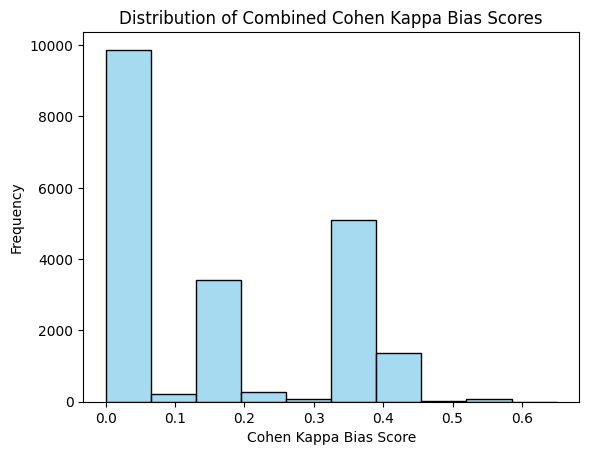

In [61]:
sns.histplot(df_train["cohen_kappa_label"], bins=10, kde=False, color='skyblue', edgecolor='black')

plt.xlabel('Cohen Kappa Bias Score')
plt.ylabel('Frequency')
plt.title('Distribution of Combined Cohen Kappa Bias Scores')
plt.show()

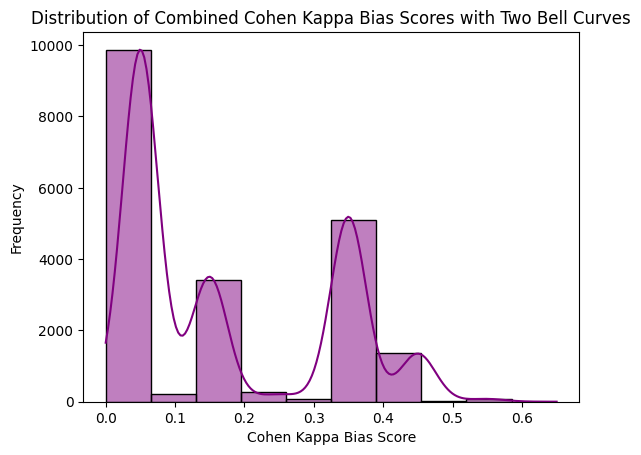

In [88]:
sns.histplot(df_train["cohen_kappa_label"], bins=10, kde=True, color='purple', edgecolor='black',
             kde_kws={'bw_method': 0.175})

plt.xlabel('Cohen Kappa Bias Score')
plt.ylabel('Frequency')
plt.title('Distribution of Combined Cohen Kappa Bias Scores with Two Bell Curves')
plt.show()

In [63]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['none_to_slight', 'fair', 'moderate', 'substantial', 'almost_perfect']

# Fill NaN values with a specific value (e.g., -1)
df_train['cohen_kappa_label'] = df_train['cohen_kappa_label'].fillna(-1)

# Use get_dummies with dummy_na parameter
df_dummies = pd.get_dummies(pd.cut(df_train['cohen_kappa_label'], bins=bins, labels=labels), dummy_na=True,
                             prefix='cohen_kappa_range', dtype=int)

# Concatenate the dummy columns to the original DataFrame
df_train = pd.concat([df_train, df_dummies], axis=1)

In [64]:
df_train

,Unnamed: 0,abstracts_headlines,section_name,cohen_kappa_label,cohen_kappa_range_none_to_slight,cohen_kappa_range_fair,cohen_kappa_range_moderate,cohen_kappa_range_substantial,cohen_kappa_range_almost_perfect,cohen_kappa_range_nan
0,0,new start treaty nearly wrapped president obama begin discussing far reaching deals russia next treaties,1,0.05,1,0,0,0,0,0
1,1,response plea israel release jonathan pollard plea pollard release,1,0.00,0,0,0,0,0,1
2,2,letters editor regarding tensions new york medical schools caribbean doctors learn best,1,0.05,1,0,0,0,0,0
3,3,canada beat united states semifinals world junior tournament advancing final th consecutive year canada beats united states world junior semifinal,0,0.35,0,1,0,0,0,0
4,4,kristine lilly holds world record international appearances u announced retirement wednesday lilly iron lady u soccer retires,0,0.05,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
20403,20403,job market remained strong last month suggesting workers remain high demand still quitting often labor department report showed workers quit february job openings stayed high,0,0.05,1,0,0,0,0,0
20404,20404,recent poll data suggests rising prices dominate americans economic concerns inflation fears highest since americans especially republicans getting worried inflation,0,0.05,1,0,0,0,0,0
20405,20405,scientists keeping eye ba one three genetically distinct varieties omicron variant coronavirus ba subvariant omicron accounts half new u coronavirus cases c c estimates,0,0.05,1,0,0,0,0,0
20406,20406,twenty one republican state attorneys general filed lawsuit biden administration tuesday block federal mask mandate public transportation twenty one states file lawsuit block mask mandate public transportation,0,0.05,1,0,0,0,0,0


In [65]:
bool_columns = [col for col in df_train.columns if type(df_train[col]) == 'bool']
df_train = df_train.drop(columns=bool_columns)

In [66]:
df_train = df_train.drop(columns='Unnamed: 0')
df_train

,abstracts_headlines,section_name,cohen_kappa_label,cohen_kappa_range_none_to_slight,cohen_kappa_range_fair,cohen_kappa_range_moderate,cohen_kappa_range_substantial,cohen_kappa_range_almost_perfect,cohen_kappa_range_nan
0,new start treaty nearly wrapped president obama begin discussing far reaching deals russia next treaties,1,0.05,1,0,0,0,0,0
1,response plea israel release jonathan pollard plea pollard release,1,0.00,0,0,0,0,0,1
2,letters editor regarding tensions new york medical schools caribbean doctors learn best,1,0.05,1,0,0,0,0,0
3,canada beat united states semifinals world junior tournament advancing final th consecutive year canada beats united states world junior semifinal,0,0.35,0,1,0,0,0,0
4,kristine lilly holds world record international appearances u announced retirement wednesday lilly iron lady u soccer retires,0,0.05,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
20403,job market remained strong last month suggesting workers remain high demand still quitting often labor department report showed workers quit february job openings stayed high,0,0.05,1,0,0,0,0,0
20404,recent poll data suggests rising prices dominate americans economic concerns inflation fears highest since americans especially republicans getting worried inflation,0,0.05,1,0,0,0,0,0
20405,scientists keeping eye ba one three genetically distinct varieties omicron variant coronavirus ba subvariant omicron accounts half new u coronavirus cases c c estimates,0,0.05,1,0,0,0,0,0
20406,twenty one republican state attorneys general filed lawsuit biden administration tuesday block federal mask mandate public transportation twenty one states file lawsuit block mask mandate public transportation,0,0.05,1,0,0,0,0,0


In [83]:
df_train.to_csv('/Users/ben/Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/Data/new_train_neg_words.csv')

### Training on the Multilabeled Data

In [70]:
df_train[df_train.columns[4:9]]

,cohen_kappa_range_fair,cohen_kappa_range_moderate,cohen_kappa_range_substantial,cohen_kappa_range_almost_perfect,cohen_kappa_range_nan
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
20403,0,0,0,0,0
20404,0,0,0,0,0
20405,0,0,0,0,0
20406,0,0,0,0,0


In [71]:
X = df_train["abstracts_headlines"]
y = df_train["cohen_kappa_label"]
'''
'rf__max_depth': None,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 100,
 'tvec__max_df': 0.6,
 'tvec__max_features': 9000,
 'tvec__min_df': 5e-05,
 'tvec__ngram_range': (1, 1)}
 '''
vectorizer = TfidfVectorizer(max_features=9000, max_df=0.6, min_df = 5e-05, ngram_range=(1, 1)) # TfidfVectorizer(max_features=2500, max_df=0.9) Resulted in 0.92 train 0.43 test 
vectorizer.fit(X)

TfidfVectorizer(max_df=0.6, max_features=9000, min_df=5e-05)

In [72]:
y

0        0.05
1        0.00
2        0.05
3        0.35
4        0.05
         ... 
20403    0.05
20404    0.05
20405    0.05
20406    0.05
20407    0.45
Name: cohen_kappa_label, Length: 20408, dtype: float64

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state=42)


X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [74]:
clf = RandomForestRegressor(max_depth = None,
                            min_samples_split=5,
                            n_estimators=100,
                            n_jobs=-1,
                            verbose=1).fit(X_train_tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


In [75]:
clf.score(X_train_tfidf, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


0.9205752979345201

In [76]:
preds = clf.predict(X_test_tfidf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [77]:
clf.score(X_test_tfidf, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.5198908410401821

### Long Run Time Warning: Random Forest GridSearch Results in Lengthy Computation Times

In [78]:
# # Pipeline with CountVectorizer and RandomForest
# rf_pipe1_a = Pipeline([
#     ('cvec', CountVectorizer()),
#     ('rf', RandomForestRegressor())
# ])

# # Pipeline with TfidfVectorizer and RandomForest
# rf_pipe2_a = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('rf', RandomForestRegressor())
# ])

# # Parameter grids for RandomForest
# rf_params1_a = {
#     'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#     'cvec__ngram_range': [(1, 1), (1, 2)],
#     'cvec__min_df': [0.00005, 0.0001],
#     'cvec__max_df': [0.6, 0.65, 0.7],
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [None, 10, 20],
#     'rf__min_samples_split': [2, 5, 10],
#     'rf__verbose': [1]
# }

# rf_params2_a = {
#     'tvec__max_features': list(np.arange(5000, 10000, 1000)),
#     'tvec__ngram_range': [(1, 1), (1, 2)],
#     'tvec__min_df': [0.00005, 0.0001],
#     'tvec__max_df': [0.6, 0.65, 0.7],
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [None, 10, 20],
#     'rf__min_samples_split': [2, 5, 10],
#     'rf__verbose': [1]
# }

# # Instantiate GridSearchCV for RandomForest
# gs_rf1_a = GridSearchCV(rf_pipe1_a,
#                         param_grid=rf_params1_a,
#                         cv=5,
#                         n_jobs=-1)

# gs_rf2_a = GridSearchCV(rf_pipe2_a,
#                         param_grid=rf_params2_a,
#                         cv=5,
#                         n_jobs=-1)

# # Measure the time taken for the parameter search
# start_time = time.time()
# gs_rf1_a.fit(X_train, y_train)
# end_time = time.time()
# print(f"Time taken for GridSearchCV with RandomForest and CountVectorizer: {end_time - start_time:.2f} seconds")

# start_time = time.time()
# gs_rf2_a.fit(X_train, y_train)
# end_time = time.time()
# print(f"Time taken for GridSearchCV with RandomForest and TfidfVectorizer: {end_time - start_time:.2f} seconds")

In [79]:
# gs_rf1_a.best_params_

In [80]:
# gs_rf2_a.best_params_

In [81]:
# gs_rf1_a.score(X_train, y_train)

In [82]:
# gs_rf1_a.score(X_test, y_test)

## Results are not satisfactory for Regression models must move to Part III LSTM Neural Network